In [3]:

import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split

import torcheval.metrics.functional as metrics

from tqdm import tqdm

import torchaudio.transforms as T




torch.manual_seed(1000) # set the random seed

In [2]:
import dill
dill.dump_session('lstm_notebook.db')


# Loading Data

In [13]:

class SleepData(Dataset):
    def __init__(self, hr_file, ecg_file, window_size=30, apply_spectrogram=False, num_outputs = 4):
        self.df1 = pd.read_csv(hr_file)
        self.df2 = pd.read_csv(ecg_file)
        self.window_size = window_size
        self.apply_spectrogram = apply_spectrogram
        self.num_outputs = num_outputs


        self.freq1 = 1
        self.freq2 = 256
        
        # Spectrogram transformation
        self.transform = T.Spectrogram(n_fft=256, normalized = True)
        

    def __len__(self):
        len1 = len(self.df1) // (self.freq1 * self.window_size)
        len2 = len(self.df2) // (self.freq2 * self.window_size)
        return round(min(len1, len2))

    def __getitem__(self, idx):
        start_window1 = self.window_size * idx * self.freq1
        start_window2 = self.window_size * idx * self.freq2
        
        # Extract heart rate data points and label for the current window
        hr = self.df1['heart_rate'].iloc[start_window1:start_window1 + self.window_size * self.freq1].values
        labels = self.df1['psg_status'].iloc[start_window1]
        
        '''
        MESA
        0: SleepStage.wake,
        1: SleepStage.n1,
        2: SleepStage.n2,
        3: SleepStage.n3,
        4: SleepStage.n4,
        5: SleepStage.rem
        
        Apple Watch:
        Awake
        Core: N1, N2
        Deep: N3 (+ N4)
        REM
        '''
        
        
        if self.num_outputs == 4:
            if labels in [1, 2]:
                labels = 1
            elif labels in [3, 4]:
                labels = 2
            elif labels == 5:
                labels = 3
        
        elif self.num_outputs == 2:
            if labels in [1, 2, 3, 4, 5]:
                labels = 1

        ecg = self.df2['ECG'].iloc[start_window2:start_window2 + self.window_size * self.freq2].values

        # Convert to PyTorch tensors
        hr = torch.tensor(hr, dtype=torch.float).unsqueeze(0)  # Add extra dimension at index 0
        labels = torch.tensor(labels, dtype=torch.long)
        ecg = torch.tensor(ecg, dtype=torch.float).unsqueeze(0)  # Add extra dimension at index 0
        
        
        if self.apply_spectrogram:
            # Apply spectrogram transformation to ECG signal
            spectrogram = self.transform(ecg)
            # Apply log transform to spectrogram
            spectrogram = T.AmplitudeToDB()(spectrogram)

            #normalize between 0 and 1 
            # Calculate the minimum and maximum values of the input data
            min_value = torch.min(spectrogram)
            max_value = torch.max(spectrogram)

            # Normalize the input data to be between 0 and 1
            spectrogram = (spectrogram - min_value) / (max_value - min_value)
                        
            return hr, spectrogram, labels
        else:
            return hr, ecg, labels


In [15]:


dataset1D = SleepData(r'/kaggle/input/hr-data/subject_0002.csv',r'/kaggle/input/ecgdata/subject_0002_ecg.csv',apply_spectrogram=False)


# Define the sizes of train, validation, and test sets
train_size = int(0.7 * len(dataset1D))  # 70% of the data for training
val_size = int(0.15 * len(dataset1D))   # 15% of the data for validation
test_size = len(dataset1D) - train_size - val_size  # Remaining data for testing

# Use random_split to split the dataset
train_dataset1D, val_dataset1D, test_datase1D = random_split(dataset1D, [train_size, val_size, test_size])



# Define batch size
batch_size = 32

# Create DataLoaders for training and validation
train_loader1D = DataLoader(train_dataset1D, batch_size=batch_size, shuffle=True)
valid_loader1D = DataLoader(val_dataset1D, batch_size=batch_size, shuffle=False)



for batch_idx, (_, ecg1D, labels1D) in enumerate(train_loader1D):
    print("Batch Index:", batch_idx)
    print("Input Shape:", ecg1D.shape)
    print("Labels Shape:", labels1D.shape)
    if batch_idx == 0:
        break




Batch Index: 0
Input Shape: torch.Size([32, 1, 7680])
Labels Shape: torch.Size([32])


In [16]:


dataset2D = SleepData(r'/kaggle/input/hr-data/subject_0002.csv',r'/kaggle/input/ecgdata/subject_0002_ecg.csv',apply_spectrogram=True)



# Define the sizes of train, validation, and test sets
train_size = int(0.7 * len(dataset2D))  # 70% of the data for training
val_size = int(0.15 * len(dataset2D))   # 15% of the data for validation
test_size = len(dataset2D) - train_size - val_size  # Remaining data for testing

# Use random_split to split the dataset
train_dataset2D, val_dataset2D, test_dataset2D = random_split(dataset2D, [train_size, val_size, test_size])



# Define batch size
batch_size = 32

# Create DataLoaders for training and validation
train_loader2D = DataLoader(train_dataset2D, batch_size=batch_size, shuffle=True)
valid_loader2D = DataLoader(val_dataset2D, batch_size=batch_size, shuffle=False)
test_loader2D = DataLoader(test_dataset2D, batch_size=batch_size, shuffle=False)



for batch_idx, (_, ecg2D, labels2D) in enumerate(train_loader2D):
    print("Batch Index:", batch_idx)
    print("Input Shape:", ecg2D.shape)
    print("Labels Shape:", labels2D.shape)
    if batch_idx == 0:
        break




Batch Index: 0
Input Shape: torch.Size([32, 1, 129, 61])
Labels Shape: torch.Size([32])


In [ ]:
#check how many are in each label/for each daatset 

# Feature Extraction

## 1. 1D CNN + LSTM

### Model 0. CNN + LSTM V1 

In [17]:



class CNNblock(nn.Module):
    def __init__(self,in_channels=1, out_channels=60,kernel_size=64):
        super(CNNblock, self,).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride = 2)
        self.dropout= nn.Dropout(p=0.25)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        return x
    

class LSTM1(nn.Module):
    def __init__(self, k1 = 64, k2 = 32, k3 = 16):
        super(LSTM1, self).__init__()
        
        # Batch normalization
        self.batchnorm = nn.BatchNorm1d(1)
        

        # Convolutional layers
        self.conv1 = CNNblock(in_channels = 1, out_channels = 60, kernel_size = k1)
        self.conv2 = CNNblock(in_channels = 60, out_channels = 30, kernel_size = k2)
        self.conv3 = CNNblock(in_channels = 30, out_channels = 10, kernel_size = k3)
        
        
        
        # GRU layers
        #self.gru1 = nn.GRU(input_size=k3, hidden_size=20, batch_first=True)
        #self.gru2 = nn.GRU(input_size=k3, hidden_size=10, batch_first=True)

        #replace with LSTM? 
        self.LSTM = nn.LSTM(input_size = 10, hidden_size = 10, bidirectional = True, num_layers = 2)
        
        
    def forward(self, x):
        # Batch normalization
        x = self.batchnorm(x)
        
       # print(x.shape)
        # Convolutional layers
        x = self.conv1(x)
        #print(x.shape)

        x = self.conv2(x)
        #print(x.shape)
        x = self.conv3(x)
        #print(x.shape)

        # Reshape for GRU input
        x = x.permute(0, 2, 1)  # Swap dimensions for RNN input
        #print(x.shape)

        # GRU layers
        #x, _ = self.gru1(x)
        #x = self.dropout4(x)
        
        #x, _ = self.gru2(x)
        #x = self.dropout(x)


        out, _ = self.LSTM(x)

        #print(out.shape)

        out_pooled = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        #print(out_pooled.shape)
        return out_pooled



In [18]:
model = LSTM1()
x = model(ecg1D)
x.shape

torch.Size([32, 40])

### 1b. CNN + LSTM V2

In [19]:
# based on: https://github.com/akaraspt/tinysleepnet

#returns features and then u can put into MLP separately 
class LSTM2(nn.Module):
    def __init__(self):
        super(LSTM2,self).__init__()
        self.pool1 = nn.MaxPool1d(8, 8) #kernel_size, stride
        self.pool2 = nn.MaxPool1d(4, 4) #kernel_size, stride

        self.conv1 = nn.Conv1d(1, 128, 8) #in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv1d(128, 128, 8) #in_channels, out_chanels, kernel_size

        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(128,128)
    

        

    def forward(self, ecg):
        
        ecg = self.pool1(ecg)
        
        ecg = self.dropout(ecg)
        ecg = F.relu(self.conv1(ecg))
        ecg = F.relu(self.conv2(ecg))
        ecg = self.pool2(F.relu(self.conv2(ecg)))
        ecg = self.dropout(ecg)

        #print(ecg.shape)

        # Transpose dimensions for LSTM input
        ecg = ecg.permute(0, 2, 1)  # Swap dimensions for RNN input
        #print(ecg.shape)
        ecg, _ = self.lstm(ecg)
        #print(ecg.shape)
        ecg = self.dropout(ecg)

        out_pooled = torch.cat([torch.max(ecg, dim=1)[0], torch.mean(ecg, dim=1)], dim=1)
        #print(ecg.shape)

        return out_pooled



In [20]:
model = LSTM2()
x = model(ecg1D)
x.shape

torch.Size([32, 256])

## 2. 2D Spectrogram

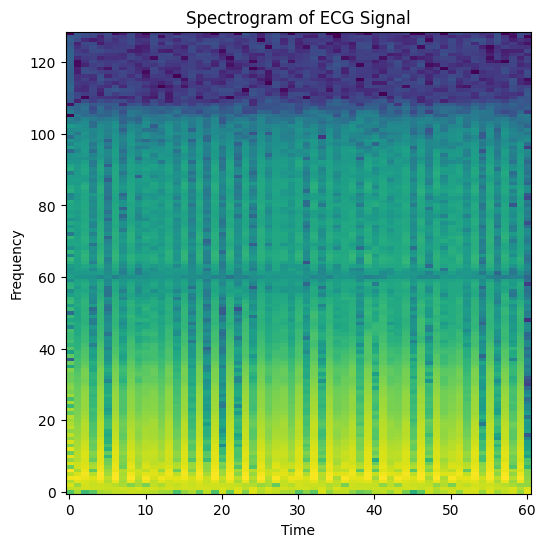

In [21]:

# Plot the spectrogram
plt.figure(figsize=(6, 6))
plt.imshow(ecg2D[4][0], origin='lower', aspect='auto')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram of ECG Signal')
plt.show()



### 2a. Spectrogram + CNN 

In [22]:
#from here  https://arxiv.org/pdf/2005.06902.pdf

class SpectrogramCNN(nn.Module):
    def __init__(self):
        super(SpectrogramCNN, self).__init__()
        
        # Spectrogram transformation
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(256, 512, kernel_size=(3, 3))
        
        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.dropout = nn.Dropout(p=0.2)
        

    def forward(self, x):

        x = F.interpolate(x, size=(256,256), mode='bicubic')

        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)

        x = F.relu(self.conv4(x))
        x = self.maxpool(x)

        # Flatten
        x = x.view(x.size(0), -1)
        
        #dropout 
        
        return x




In [23]:
model = SpectrogramCNN()
x = model(ecg2D)
x.shape

torch.Size([32, 100352])

### 2b. Spectrogram + AlexNet Features

In [24]:

import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 57.7MB/s] 


In [25]:
x = F.interpolate(ecg2D, size=(227,227), mode='bicubic')
rgb_x = x.repeat(1,3, 1, 1)
print(rgb_x.shape)
features = alexnet.features(rgb_x)
print(features.shape)



torch.Size([32, 3, 227, 227])
torch.Size([32, 256, 6, 6])


In [26]:
#pre-extract AlexNet Features
#i'm doing it here bc i don't wanna load alexnet in the training loop but idk if this computationally better
train_datasetAN, val_datasetAN, test_datasetAN = [], [], []

for hr, ecg, labels in tqdm(train_dataset2D):
    x = ecg.unsqueeze(0)
    x = F.interpolate(x, size=(227,227), mode='bicubic')
    x = x.repeat(1,3, 1, 1)
    features = alexnet.features(x)
    features = features.squeeze()
    train_datasetAN.append([hr, features, labels])

for hr, ecg, labels in tqdm(val_dataset2D):
    x = ecg.unsqueeze(0)
    x = F.interpolate(x, size=(227,227), mode='bicubic')
    x = x.repeat(1,3, 1, 1)
    features = alexnet.features(x)
    features = features.squeeze()
    val_datasetAN.append([hr,features, labels])

for hr, ecg, labels in tqdm(test_dataset2D):
    x = ecg.unsqueeze(0)
    x = F.interpolate(x, size=(227,227), mode='bicubic')
    x = x.repeat(1,3, 1, 1)
    features = alexnet.features(x)
    features = features.squeeze()
    test_datasetAN.append([hr, features, labels])





100%|██████████| 156/156 [00:02<00:00, 76.74it/s]


In [27]:
x.shape

torch.Size([1, 3, 227, 227])

In [28]:
# Define batch size
batch_size = 32

# Create DataLoaders for training and validation
train_loaderAN = DataLoader(train_datasetAN, batch_size=batch_size, shuffle=True)
valid_loaderAN = DataLoader(val_datasetAN, batch_size=batch_size, shuffle=False)



for batch_idx, (_, ecgAN, labelsAN) in enumerate(train_loaderAN):
    print("Batch Index:", batch_idx)
    print("Input Shape:", ecgAN.shape)
    print("Labels Shape:", labelsAN.shape)
    if batch_idx == 0:
        break


Batch Index: 0
Input Shape: torch.Size([32, 256, 6, 6])
Labels Shape: torch.Size([32])


In [ ]:
#can also just try trainign alexnet myself 

# Final Classifier + Testing

## 1D

In [60]:
class Classifier1D(nn.Module):
    def __init__(self, out_size = 4, hidden_size1 = 64, hidden_size2 = 32, model = 0):
        super(Classifier1D, self).__init__()

        if model == 0:
            self.mymodel = LSTM1()
            self.in_size = 40

        elif model == 1:
            self.mymodel = LSTM2()
            self.in_size = 256


        if use_cuda and torch.cuda.is_available():
            self.mymodel.cuda()
        if out_size == 2:
            self.out_size = 1
        else:
            self.out_size = out_size


        self.fc1 = nn.Linear(self.in_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, self.out_size)
        
    def forward(self,x):
        
        out = self.mymodel(x)
        

        #print(out.shape)
        #flatten
        out = out.view(-1, self.in_size)
        

        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        #print(out.shape)
        out = self.fc3(out)

        #print(out.shape)
        out = out.squeeze(1) # Flatten to [batch_size]
        #print(out.shape)
        return out
        

In [61]:
use_cuda = False
model= Classifier1D(model = 0)

x= model(ecg1D)
x.shape

torch.Size([32, 4])

## 2D 

In [62]:
class Classifier2D(nn.Module):
    def __init__(self, out_size = 4, hidden_size1 = 64, hidden_size2 = 32, model = 0):
        super(Classifier2D, self).__init__()

        self.mymodel = SpectrogramCNN()
        self.in_size = 100352 
        
        
        if use_cuda and torch.cuda.is_available():
            self.mymodel.cuda()

        
        
        if out_size == 2:
            self.out_size = 1
        else:
            self.out_size = out_size


        self.fc1 = nn.Linear(self.in_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, self.out_size)

        
    def forward(self,x):
        
        

        #print(x.shape)
        out = self.mymodel(x)
        #print(out.shape)
 
        #flatten
        out = out.view(-1, self.in_size)
        #print(out.shape)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        #print(out.shape)
        out = self.fc3(out)
        #print(out.shape)
        out = out.squeeze(1) # Flatten to [batch_size]
        #print(out.shape)
        return out
        

In [32]:

class ClassifierAN(nn.Module):
    def __init__(self, l1 = 64, l2 = 32):
        super(ClassifierAN, self).__init__()
        
        if out_size == 2:
            self.out_size = 1
        else:
            self.out_size = out_size
        
        self.fc1 = nn.Linear(256 * 6 * 6, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, out_size)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [63]:
model = Classifier2D(model = 0)
x = model(ecg2D)
x.shape


torch.Size([32, 4])

In [34]:
model = ClassifierAN()
x = model(ecgAN)
x.shape


torch.Size([32, 4])

# Training

In [41]:

def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=0.001,num_classes = 4):


    #calculate class weights (bc unblanced data)
    labels = []
    
    for batch in train_loader:
        _, _, label_batch = batch
        labels.append(label_batch)
    labels = torch.cat(labels, dim=0)

    class_counts = torch.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (len(class_counts) * class_counts.float())
    class_weights /= class_weights.sum()


    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        class_weights = class_weights.cuda()
    #############################################

    
    if num_classes == 2 #binary classification
        criterion = nn.BCEWithLogitsLoss(weight = class_weights)
    else
        criterion = nn.CrossEntropyLoss(weight = class_weights)


    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc, valid_losses = [], [], [], []
    epochs = []

    best_valid_acc = 0.0  # Initialize best validation accuracy
    best_model_state = None  # Initialize best model parameters

    for epoch in range(num_epochs):
        for _,ecg,labels in train_loader:
            ecg.detach_()
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                ecg = ecg.cuda()
                labels = labels.cuda()


            optimizer.zero_grad()
            pred = model(ecg)

            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            
            
        
        losses.append(float(loss))

        
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            #for x in tqdm(iter(valid_loader)):
             # Evaluate validation loss on the first batch only
            val_data_iter = iter(valid_loader)
            x = next(val_data_iter)

            if use_cuda and torch.cuda.is_available():
                ecg = ecg.cuda()
                labels = labels.cuda()

            pred = model(ecg)
            loss = criterion(pred, labels)
            valid_losses.append(float(loss))

        if epoch % 10 == 9:
            epochs.append(epoch)
            train_acc.append(get_accuracy(model, train_loader, num_classes))
            # Calculate validation accuracy and loss
            valid_acc.append(get_accuracy(model, valid_loader,num_classes))

            print("Epoch %d; Train Loss %f; Train Acc %f; Val loss %f; Val Acc %f" % (
              epoch+1, losses[-1], train_acc[-1],valid_losses[-1], valid_acc[-1]))

            if valid_acc[-1] > best_valid_acc:
              best_valid_acc = valid_acc[-1]
              best_model_state = model.state_dict()

        model.train()
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    print("Best Valid Acc:",best_valid_acc)

    return best_model_state










In [36]:
def get_accuracy(model, data_loader,num_classes = 4):
    model.eval()

    correct, total = 0, 0
    with torch.no_grad():
        for _,ecg,labels in data_loader:
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                ecg = ecg.cuda()
                labels = labels.cuda()
            #############################################
            output = model(ecg)

            if num_classes ==2:
                pred = (torch.sigmoid(output) >= 0.5).float()
            else: 
                pred = output.max(1, keepdim=True)[1]
        
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += labels.shape[0]
    return correct / total






In [90]:
def get_accuracy2(model, data_loader, num_classes = 4):
    model.eval()

    correct, total = 0, 0
    pred_out,labels_out= [], []
    with torch.no_grad():
      for _,ecg,labels in data_loader:
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              ecg = ecg.cuda()
              labels = labels.cuda()
            #############################################
            output = model(ecg)
            if num_classes ==1:
                pred = (torch.sigmoid(output) >= 0.5).float()
            else: 
                pred = output.max(1, keepdim=True)[1]
    
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += labels.shape[0]
            labels_out.append(labels)
            pred_out.append(pred)
    return correct / total, labels_out, pred_out



In [38]:
print(model)

ClassifierAN(
  (fc1): Linear(in_features=9216, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


Epoch 10; Train Loss 1.393829; Train Acc 0.182825; Val loss 1.393253; Val Acc 0.149351
Epoch 20; Train Loss 1.352675; Train Acc 0.182825; Val loss 1.351755; Val Acc 0.149351
Epoch 30; Train Loss 1.369072; Train Acc 0.209141; Val loss 1.369115; Val Acc 0.201299
Epoch 40; Train Loss 1.392849; Train Acc 0.368421; Val loss 1.391430; Val Acc 0.396104
Epoch 50; Train Loss 1.392000; Train Acc 0.386427; Val loss 1.392362; Val Acc 0.402597
Epoch 60; Train Loss 1.370646; Train Acc 0.465374; Val loss 1.376305; Val Acc 0.480519
Epoch 70; Train Loss 1.301052; Train Acc 0.501385; Val loss 1.279086; Val Acc 0.525974
Epoch 80; Train Loss 1.059930; Train Acc 0.573407; Val loss 1.115126; Val Acc 0.662338
Epoch 90; Train Loss 0.859683; Train Acc 0.565097; Val loss 0.884533; Val Acc 0.623377
Epoch 100; Train Loss 0.992933; Train Acc 0.562327; Val loss 1.008967; Val Acc 0.636364
Epoch 110; Train Loss 1.097270; Train Acc 0.565097; Val loss 1.127710; Val Acc 0.636364
Epoch 120; Train Loss 1.040792; Train Acc

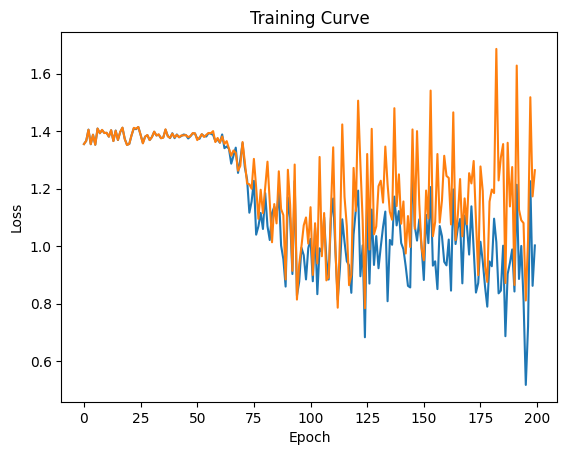

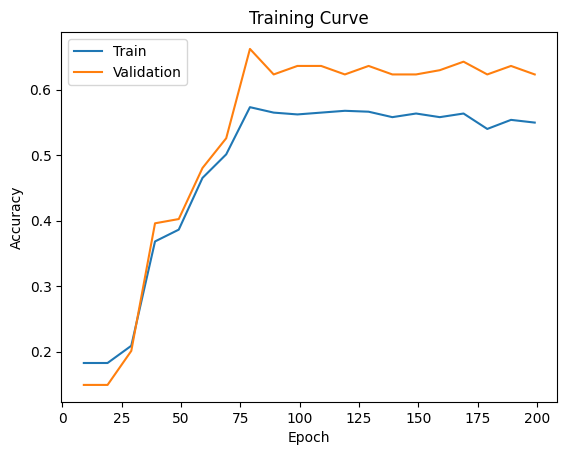

Best Valid Acc: 0.6623376623376623


In [66]:
#training LSTM v1 
use_cuda = True
model= Classifier1D(model = 0)
model = model.cuda()

train_network(model, train_loader1D, valid_loader1D, num_epochs=200, learning_rate=0.0001);


Epoch 10; Train Loss 1.387348; Train Acc 0.267313; Val loss 1.386945; Val Acc 0.311688
Epoch 20; Train Loss 1.369799; Train Acc 0.437673; Val loss 1.373356; Val Acc 0.428571
Epoch 30; Train Loss 1.290227; Train Acc 0.494460; Val loss 1.353965; Val Acc 0.512987
Epoch 40; Train Loss 1.258621; Train Acc 0.547091; Val loss 1.313168; Val Acc 0.584416
Epoch 50; Train Loss 0.975680; Train Acc 0.573407; Val loss 1.068496; Val Acc 0.642857
Epoch 60; Train Loss 0.988027; Train Acc 0.572022; Val loss 1.037947; Val Acc 0.649351
Epoch 70; Train Loss 0.870709; Train Acc 0.577562; Val loss 0.902326; Val Acc 0.649351
Epoch 80; Train Loss 1.078388; Train Acc 0.565097; Val loss 1.134285; Val Acc 0.649351
Epoch 90; Train Loss 0.907501; Train Acc 0.563712; Val loss 0.868775; Val Acc 0.616883
Epoch 100; Train Loss 1.093082; Train Acc 0.578947; Val loss 1.077519; Val Acc 0.668831
Epoch 110; Train Loss 0.953081; Train Acc 0.584488; Val loss 1.018219; Val Acc 0.681818
Epoch 120; Train Loss 0.992518; Train Acc

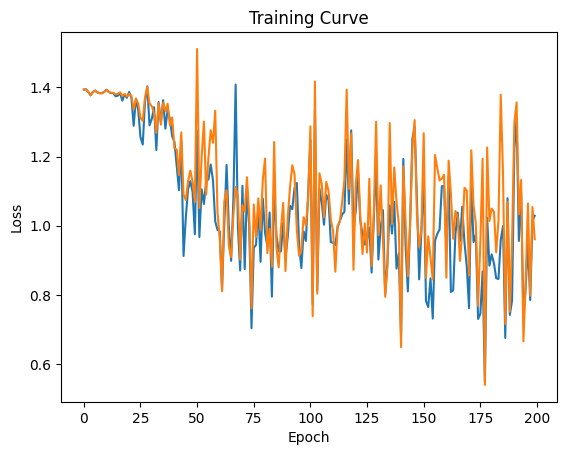

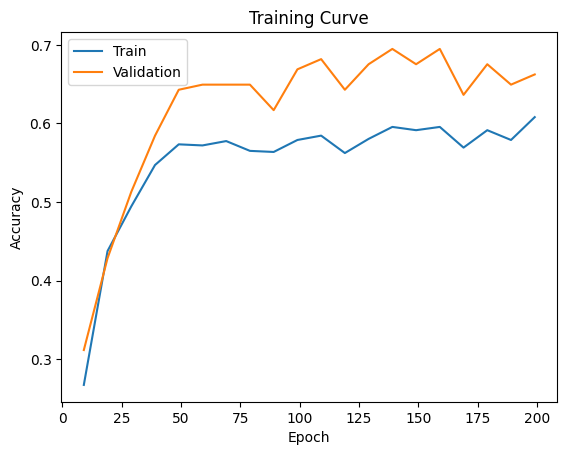

Best Valid Acc: 0.6948051948051948


In [69]:
#training LSTM v1 
use_cuda = True
model= Classifier1D(model = 0,hidden_size1 = 128, hidden_size2 = 64)
model = model.cuda()

train_network(model, train_loader1D, valid_loader1D, num_epochs=200, learning_rate=0.0001);


Epoch 10; Train Loss 1.383605; Train Acc 0.390582; Val loss 1.383009; Val Acc 0.428571
Epoch 20; Train Loss 1.377709; Train Acc 0.393352; Val loss 1.388787; Val Acc 0.441558
Epoch 30; Train Loss 1.372151; Train Acc 0.419668; Val loss 1.357376; Val Acc 0.461039
Epoch 40; Train Loss 1.289718; Train Acc 0.469529; Val loss 1.264281; Val Acc 0.467532
Epoch 50; Train Loss 1.134368; Train Acc 0.483380; Val loss 1.215308; Val Acc 0.538961
Epoch 60; Train Loss 1.165699; Train Acc 0.502770; Val loss 1.096951; Val Acc 0.525974
Epoch 70; Train Loss 1.160277; Train Acc 0.484765; Val loss 1.172203; Val Acc 0.409091
Epoch 80; Train Loss 1.329412; Train Acc 0.486150; Val loss 1.150149; Val Acc 0.402597
Epoch 90; Train Loss 1.282437; Train Acc 0.506925; Val loss 1.364313; Val Acc 0.448052
Epoch 100; Train Loss 1.081951; Train Acc 0.534626; Val loss 1.142112; Val Acc 0.467532
Epoch 110; Train Loss 1.285193; Train Acc 0.551247; Val loss 1.196929; Val Acc 0.500000
Epoch 120; Train Loss 1.137497; Train Acc

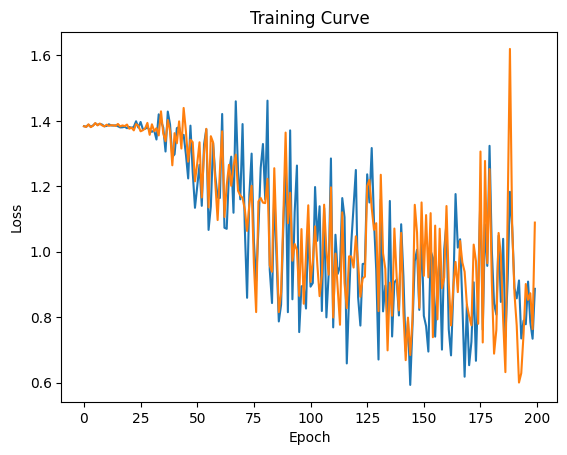

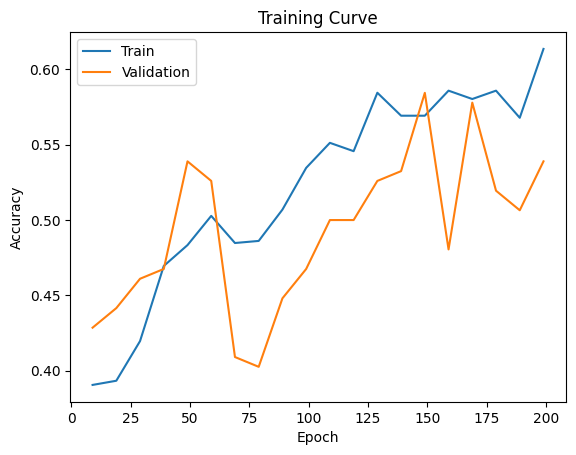

Best Valid Acc: 0.5844155844155844


In [74]:
#training LSTM v1 
use_cuda = True
model= Classifier1D(model = 0,hidden_size1 = 256, hidden_size2 = 128)
model = model.cuda()

train_network(model, train_loader1D, valid_loader1D, num_epochs=200, learning_rate=0.0001);


Epoch 10; Train Loss 1.395205; Train Acc 0.267313; Val loss 1.395697; Val Acc 0.311688
Epoch 20; Train Loss 1.370579; Train Acc 0.267313; Val loss 1.369590; Val Acc 0.311688
Epoch 30; Train Loss 1.357474; Train Acc 0.267313; Val loss 1.357131; Val Acc 0.311688
Epoch 40; Train Loss 1.366187; Train Acc 0.267313; Val loss 1.378886; Val Acc 0.311688
Epoch 50; Train Loss 1.399983; Train Acc 0.267313; Val loss 1.409607; Val Acc 0.311688
Epoch 60; Train Loss 1.387826; Train Acc 0.267313; Val loss 1.399085; Val Acc 0.311688
Epoch 70; Train Loss 1.370275; Train Acc 0.220222; Val loss 1.378534; Val Acc 0.233766
Epoch 80; Train Loss 1.382877; Train Acc 0.211911; Val loss 1.385995; Val Acc 0.227273
Epoch 90; Train Loss 1.385100; Train Acc 0.214681; Val loss 1.386096; Val Acc 0.220779
Epoch 100; Train Loss 1.297426; Train Acc 0.221607; Val loss 1.345795; Val Acc 0.220779
Epoch 110; Train Loss 1.354143; Train Acc 0.200831; Val loss 1.373081; Val Acc 0.162338
Epoch 120; Train Loss 1.406016; Train Acc

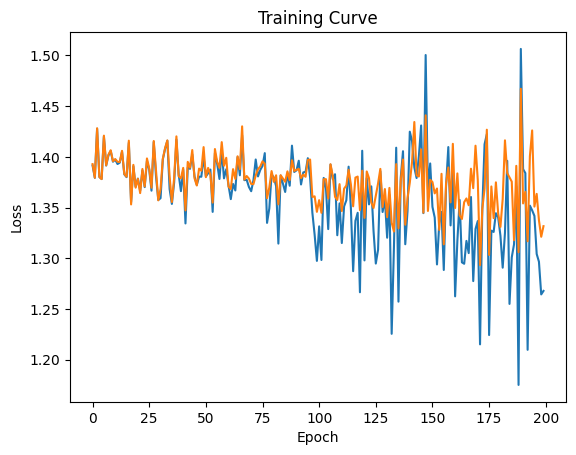

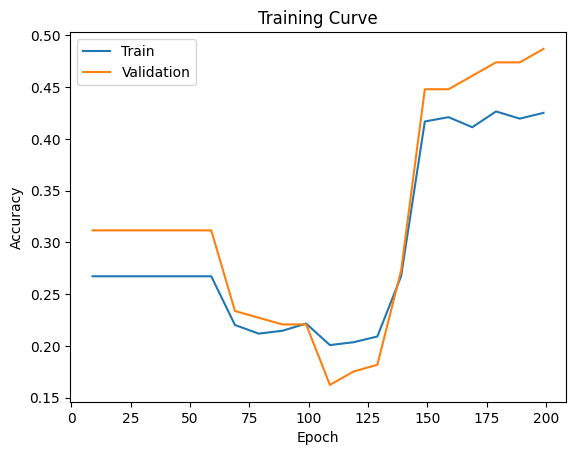

Best Valid Acc: 0.487012987012987


In [68]:
#LSTM V2 -  this one doesn't work
use_cuda = True
model= Classifier1D(model = 1)
model = model.cuda()

train_network(model, train_loader1D, valid_loader1D, num_epochs=200, learning_rate=0.00001);


Epoch 10; Train Loss 1.372309; Train Acc 0.182825; Val loss 1.372092; Val Acc 0.149351
Epoch 20; Train Loss 1.391663; Train Acc 0.186981; Val loss 1.393153; Val Acc 0.168831
Epoch 30; Train Loss 1.374823; Train Acc 0.188366; Val loss 1.374254; Val Acc 0.188312
Epoch 40; Train Loss 1.386713; Train Acc 0.200831; Val loss 1.386268; Val Acc 0.201299
Epoch 50; Train Loss 1.371910; Train Acc 0.206371; Val loss 1.379434; Val Acc 0.227273
Epoch 60; Train Loss 1.393264; Train Acc 0.397507; Val loss 1.388296; Val Acc 0.402597
Epoch 70; Train Loss 1.359013; Train Acc 0.411357; Val loss 1.387716; Val Acc 0.422078
Epoch 80; Train Loss 1.390264; Train Acc 0.414127; Val loss 1.380213; Val Acc 0.441558
Epoch 90; Train Loss 1.389509; Train Acc 0.423823; Val loss 1.370397; Val Acc 0.467532
Epoch 100; Train Loss 1.403522; Train Acc 0.421053; Val loss 1.402080; Val Acc 0.474026
Epoch 110; Train Loss 1.370040; Train Acc 0.419668; Val loss 1.381025; Val Acc 0.480519
Epoch 120; Train Loss 1.321875; Train Acc

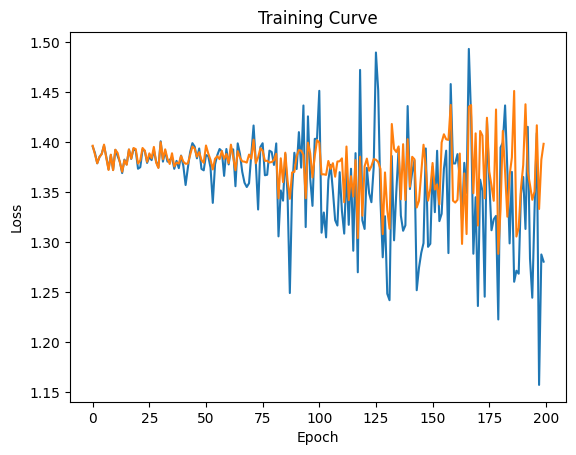

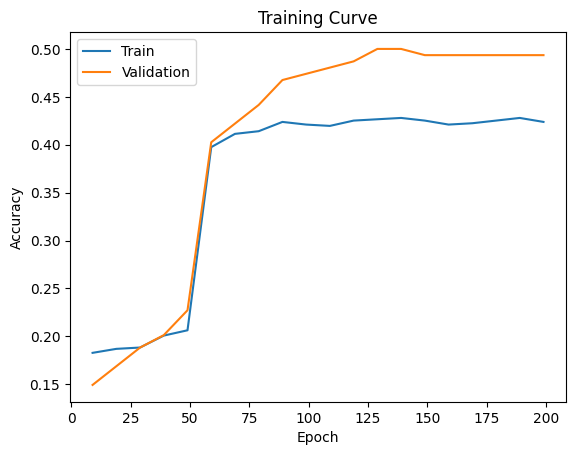

Best Valid Acc: 0.5


In [70]:
#LSTM V2
use_cuda = True
model= Classifier1D(model = 1,hidden_size1 = 128, hidden_size2 = 64)
model = model.cuda()

train_network(model, train_loader1D, valid_loader1D, num_epochs=200, learning_rate=0.00001);


Epoch 10; Train Loss 1.079539; Train Acc 0.427978; Val loss 1.056473; Val Acc 0.454545
Epoch 20; Train Loss 0.836935; Train Acc 0.530471; Val loss 0.765023; Val Acc 0.512987
Epoch 30; Train Loss 0.659807; Train Acc 0.650970; Val loss 0.627323; Val Acc 0.577922
Epoch 40; Train Loss 0.417040; Train Acc 0.747922; Val loss 0.382191; Val Acc 0.616883
Epoch 50; Train Loss 0.294731; Train Acc 0.847645; Val loss 0.249184; Val Acc 0.584416
Epoch 60; Train Loss 0.115048; Train Acc 0.940443; Val loss 0.072702; Val Acc 0.649351
Epoch 70; Train Loss 0.008534; Train Acc 0.998615; Val loss 0.008994; Val Acc 0.636364
Epoch 80; Train Loss 0.001955; Train Acc 1.000000; Val loss 0.001942; Val Acc 0.623377
Epoch 90; Train Loss 0.001318; Train Acc 1.000000; Val loss 0.001253; Val Acc 0.623377
Epoch 100; Train Loss 0.000329; Train Acc 1.000000; Val loss 0.000323; Val Acc 0.616883


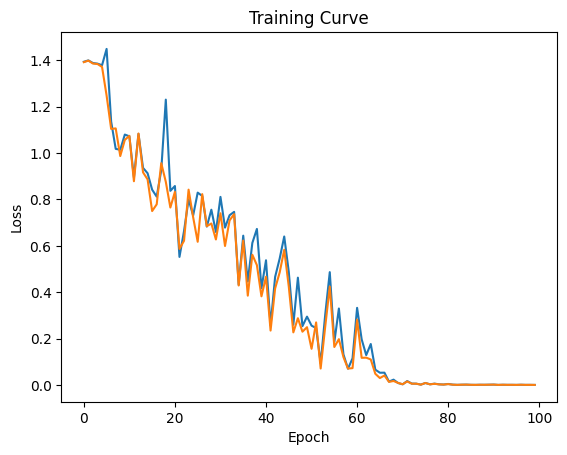

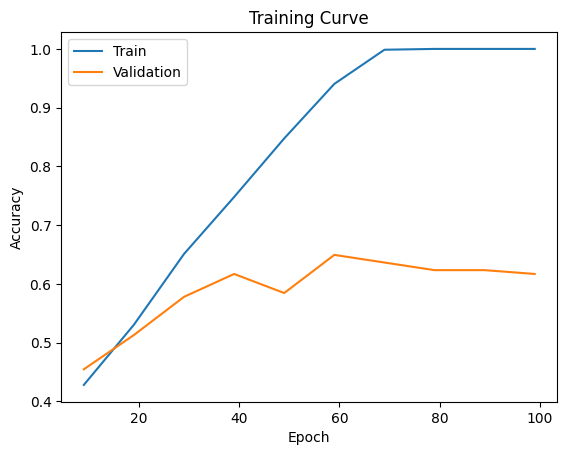

Best Valid Acc: 0.6493506493506493


In [95]:
#conv network
use_cuda = True
model= Classifier2D()
model = model.cuda()

train_network(model, train_loader2D, valid_loader2D, num_epochs=100, learning_rate=0.001);


Epoch 10; Train Loss 1.348120; Train Acc 0.383657; Val loss 1.234870; Val Acc 0.344156
Epoch 20; Train Loss 1.102649; Train Acc 0.439058; Val loss 1.012077; Val Acc 0.415584
Epoch 30; Train Loss 0.667850; Train Acc 0.580332; Val loss 0.668213; Val Acc 0.500000
Epoch 40; Train Loss 0.454212; Train Acc 0.653740; Val loss 0.438328; Val Acc 0.519481
Epoch 50; Train Loss 0.294236; Train Acc 0.833795; Val loss 0.238521; Val Acc 0.577922
Epoch 60; Train Loss 0.061691; Train Acc 0.979224; Val loss 0.038046; Val Acc 0.545455
Epoch 70; Train Loss 0.003824; Train Acc 1.000000; Val loss 0.003645; Val Acc 0.532468
Epoch 80; Train Loss 0.000744; Train Acc 1.000000; Val loss 0.000730; Val Acc 0.538961
Epoch 90; Train Loss 0.000192; Train Acc 1.000000; Val loss 0.000187; Val Acc 0.545455
Epoch 100; Train Loss 0.000085; Train Acc 1.000000; Val loss 0.000080; Val Acc 0.525974
Epoch 110; Train Loss 0.000026; Train Acc 1.000000; Val loss 0.000026; Val Acc 0.545455
Epoch 120; Train Loss 0.000040; Train Acc

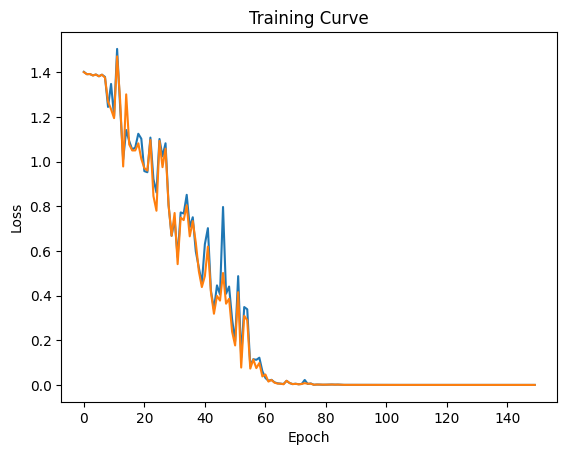

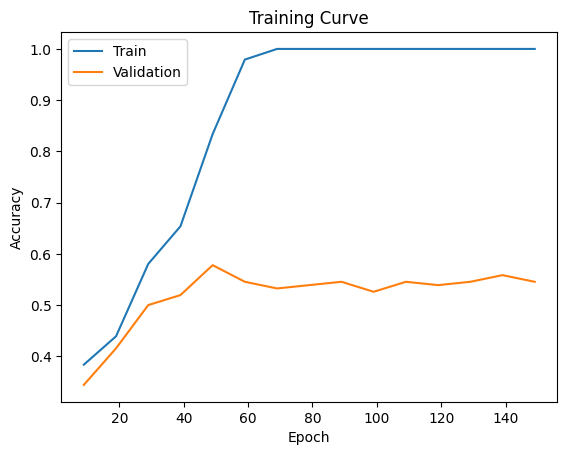

Best Valid Acc: 0.577922077922078


In [97]:
#conv network
use_cuda = True
model= Classifier2D(hidden_size1 = 128, hidden_size2 = 64)
model = model.cuda()

train_network(model, train_loader2D, valid_loader2D, num_epochs=150, learning_rate=0.001);


Epoch 10; Train Loss 0.808529; Train Acc 0.623269; Val loss 0.802345; Val Acc 0.603896
Epoch 20; Train Loss 0.645306; Train Acc 0.734072; Val loss 0.626936; Val Acc 0.629870
Epoch 30; Train Loss 0.715564; Train Acc 0.778393; Val loss 0.704141; Val Acc 0.655844
Epoch 40; Train Loss 0.471379; Train Acc 0.836565; Val loss 0.467399; Val Acc 0.662338
Epoch 50; Train Loss 0.371059; Train Acc 0.876731; Val loss 0.363525; Val Acc 0.688312
Epoch 60; Train Loss 0.325872; Train Acc 0.930748; Val loss 0.324412; Val Acc 0.701299
Epoch 70; Train Loss 0.299344; Train Acc 0.944598; Val loss 0.289223; Val Acc 0.701299
Epoch 80; Train Loss 0.218787; Train Acc 0.963989; Val loss 0.218146; Val Acc 0.681818
Epoch 90; Train Loss 0.203955; Train Acc 0.979224; Val loss 0.200989; Val Acc 0.694805
Epoch 100; Train Loss 0.118314; Train Acc 0.988920; Val loss 0.114361; Val Acc 0.694805
Epoch 110; Train Loss 0.101475; Train Acc 0.994460; Val loss 0.096988; Val Acc 0.694805
Epoch 120; Train Loss 0.072962; Train Acc

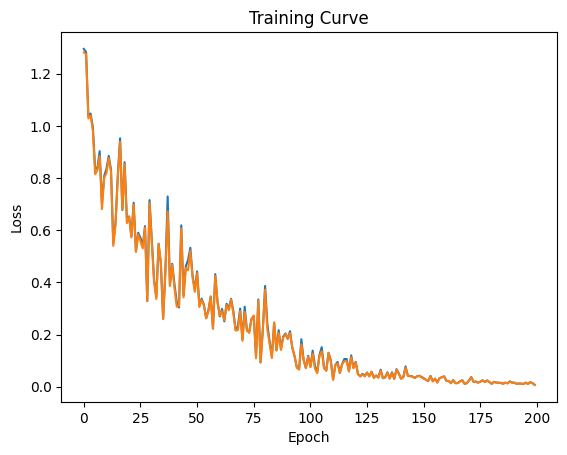

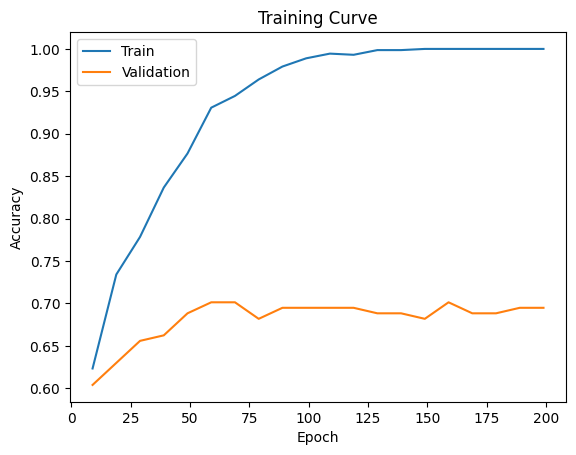

Best Valid Acc: 0.7012987012987013


In [81]:
model = ClassifierAN()
x = model(ecgAN)
model.cuda()

train_network(model, train_loaderAN, valid_loaderAN, num_epochs=200, learning_rate=0.0001);

TODO: hyperparameter tuning
* hidden size in FC part
* add dropout
* architecture of feature extraction part
    * LSTM settings
    * conv kernel size + filters


TODO: confusion matrix

TODO: try classifying sleep/wake only

TODO: try adding extracted features (at the classifier step) - you'll need to completely rewrite your dataloader to take in the feature extraction code